Here is the problem we set out to day:
to estimate blood concentrations of estradol at all hours of day,
given a particular dosing regime and blood tests taken at a particular time.
I am honestly surprised noone has done this.
The intersection of trans folk and scientific computing is non-trivial.

To do this we are going to use probabablistic programming.
This is a great usecase for probablistic programming.
We have a ton of domain knowledge, but that domain knowledge has a few (not many) parameters we don't know, and we have only a little data.
Furthermore we would love to get a distribution over possible answers out of the system.


From [this blog post on Sublingual versus Oral Estrogen](http://transascity.org/sublingual-versus-oral-estrogen/) they approximated the estradoil function with a linear to the peak then an expodential decay.

> I plotted points from the sublingual estradiol curve, and came up with an estimate of the estradiol function from 1 hr to 24 hours as being `350.54*(HOURS^-0.907)`. From 0 to 1 hours, I estimated the estradiol level linearly, as `451*HOURS`.


I am today interested in the estradiol function for estradiol gel.
It's the same shape, so a similar strategy should apply.


Järvinen A, Granander M, Nykänen S, Laine T, Geurts P, Viitanen A (November 1997). "Steady-state pharmacokinetics of oestradiol gel in post-menopausal women: effects of application area and washing". Br J Obstet Gynaecol. 104 Suppl 16: 14–8. doi:10.111/j.1471-0528.1997.tb11562.x. PMID 9389778. S2CID 36677042.
give 3 curves for single dose.
Which are also available from Wikimedia Commons. Plots below:
![](https://upload.wikimedia.org/wikipedia/commons/1/19/Estradiol_levels_with_1_mg_per_day_transdermal_estradiol_gel_applied_to_different_amounts_of_area_in_postmenopausal_women.png)
These 3 curve in that study were from different application areas.
For our purposes that doesn't matter.
We instead can characterise them as 3 different realistic curves, which have some differences based on various causes (be they application area, location, physiology etc).
We will then estimate the parameters of those curves.

In [ ]:
using Pkg: @pkg_str
#pkg"activate --temp"
pkg"add Tables@1 Plots@1 Turing@0.21.12 MCMCChains@5.5"

In [ ]:
function single_dose(c_max, halflife, t_max)
    function(t)
        if t < t_max
            c_max/t_max * t
        else
            c_max * 2^(-(t-t_max)/halflife)
        end
    end
end

Let's see how we did.
I am going to plot the data from Järvinen et al against curves using my formula, best fit by my own inspection.
I am downshifting all the data from Järvinen by 25 pg/mL, as that data was from postmenopausal cis women, who produce about 25 pg/mL of estradoil on their own before you take into account HRT.
We only want to model the HRT component.

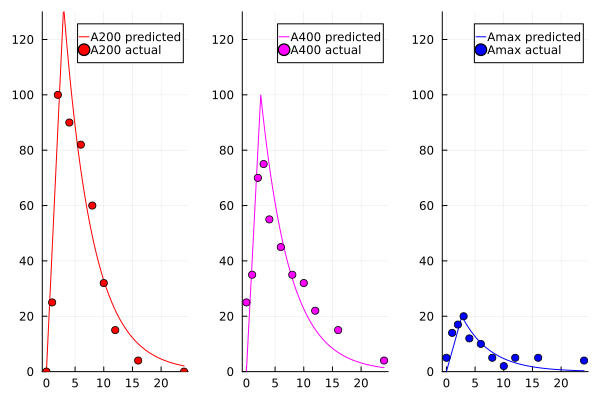

In [159]:
using Plots
plot(layout=(1,3))

plot!(
    0:0.1:24, single_dose(132, 3.5, 3),
    label="A200 predicted"; linecolor=:red, subplot=1, yrange=(0,130),
)
scatter!(
    [0,1,2,3,4,6,8,10,12,16,24],[25,50,125,157,115,107,85,57,40,29] .- 25;
    label="A200 actual", markercolor=:red, subplot=1, yrange=(0,130),
)

plot!(
    single_dose(100, 3.5, 2.5),
    label="A400 predicted", linecolor=:magenta, subplot=2, yrange=(0,130),
)
scatter!(
    [0,1,2,3,4,6,8,10,12,16,24],[50,60,95,100,80,70,60,57,47,40,29] .- 25;
    label="A400 actual", markercolor=:magenta, subplot=2, yrange=(0,130),
)

plot!(
    single_dose(20, 3.5, 2.7),
    label="Amax predicted", linecolor=:blue, subplot=3, yrange=(0,130),
)
scatter!(
    [0,1,2,3,4,6,8,10,12,16,24],[30, 39,42,45,37,35,30,27,30,30,29] .- 25;
    label="Amax actual", markercolor=:blue, subplot=3, yrange=(0,130),
)

By looking at these plots, it seems a pretty decent model.
Of-course with enough degrees of freedom, you can fit an elephant.
However we have 10 points and only 3 degrees of freedom, of which we only varied 2 of them across the 3 datasets.
So it seems like we are good.

It's broadly biologically plausable.
We expect a fast intial absorbsion, that should end at some point in few few hours -- 1-4 is various comments on how long to avoid showering on the packets depending on brand.
Since it is fast and short, it doesn't really matter what we model it with, so linear is fine.
Then we expect a tail off as it is consumed.
It makes sense for the rate of absorbsion to be related to the quanity remaining -- which suggests some expodential.
We expect this because the more estradol bumping around the higher the chance of one of them hitting a receptor and being consumed.
This might be nonsense, I am no systems biologist.



In [180]:
using Turing

@model function single_dose_model()
    c_max ~ truncated(Normal(100, 100), 0, Inf)
    halflife ~ truncated(Normal(3.5, 0.5), 0, 4)
    t_max ~ truncated(Normal(3, 0.5), 1, 9)
    
    dose_f = single_dose(c_max, halflife, t_max)
    c1 = dose_f(1)
    c2 = dose_f(2)
    c3 = dose_f(3)
    c4 = dose_f(4)
    c6 = dose_f(6)
    c8 = dose_f(8)
    c10 = dose_f(10)
    c12 = dose_f(12)
    c16 = dose_f(16)
    c24 = dose_f(24)
    
    return (c1, c2,c3, c4, c6, c8, c10,c12, c16, c24)
end


single_dose_model (generic function with 2 methods)

In [183]:
model = single_dose_model() | map(x->x-25, (c1=50,c2=60,c3=95,c4=100,c6=80,c8=70,c9=60,c10=57,c12=47,c16=40,c24=29))
sampler = HMC(0.01, 100);

chain=sample(model, sampler, 10_000)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


Chains MCMC chain (10000×12×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 2.54 seconds
Compute duration  = 2.54 seconds
parameters        = c_max, halflife, t_max
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, step_size, nom_step_size

Summary Statistics
  parameters       mean       std   naive_se      mcse           ess      rhat ⋯
      Symbol    Float64   Float64    Float64   Float64       Float64   Float64 ⋯

       c_max   128.7106   79.1582     0.7916    1.2159     4342.2953    1.0002 ⋯
    halflife     3.3567    0.4025     0.0040    0.0087     2737.8168    1.0000 ⋯
       t_max     3.0003    0.4959     0.0050    0.0016   126135.9413    1.0000 ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%      50.0%      75.0%      97.5% 
      Symbol   Float64   Float64

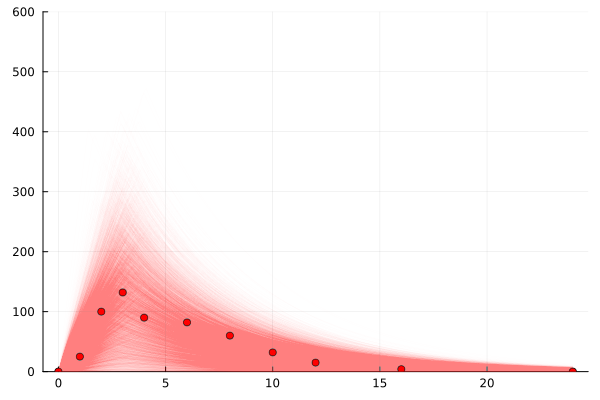

In [184]:
using Tables

gr(fmt=:png)  # make sure not to plot svg or will crash browser
scatter(
    [0,1,2,3,4,6,8,10,12,16,24],[25,50,125,157,115,107,85,57,40,29] .- 25;
    label="A200 actual", markercolor=:red, subplot=1, yrange=(0,130),
    legend=false
)

for samp in rowtable(chain)
    f = single_dose(samp.c_max, samp.halflife, samp.t_max)
    plot!(
        0:0.1:24, f,
        linealpha=0.005, linecolor=:red, subplot=1, yrange=(0,600),
    )
end
plot!()

In [ ]:
function multi_dose(period=12, t_end=100)
    c = OffsetVector(zeros(t_end+1), 0:t_end)
    for i in eachindex(c)
        if i % period == 0
            s_dose = single_dose()
            for j in eachindex(s_dose)
                (i + j) > lastindex(c) && break
                c[i+j] += s_dose[j]
            end
        end
    end
    return c
end
dose = multi_dose()
plot(dose)
scatter!(dose)